In [1]:
from manim import *
import jupyter_capture_output

video_scene = " -v WARNING --progress_bar None --disable_caching ct_Scene"
image_scene = f" -v WARNING --progress_bar None --disable_caching -r {2*427},{2*240}  -s ct_Scene"

Manim Community v0.17.3

Jupyter Capture Output v0.0.11


Output saved by creating file at animations/christmas_tree/christmas_tree.mp4.


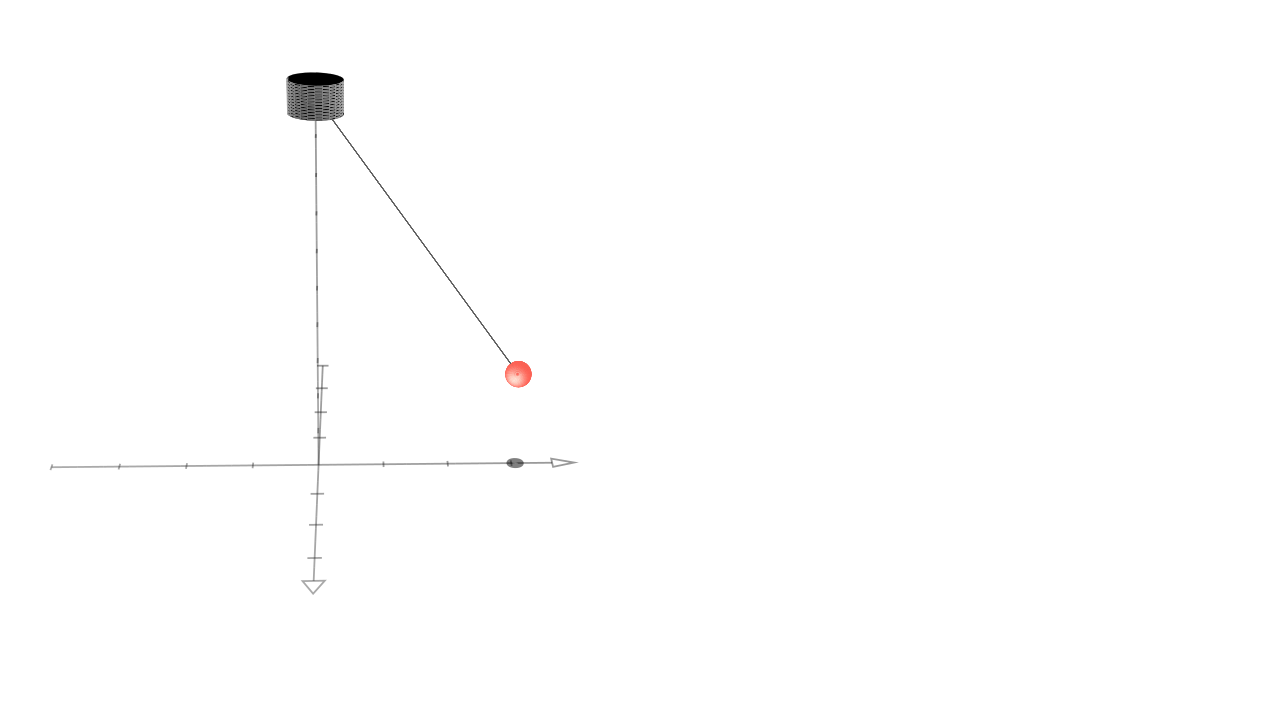

In [118]:
%%capture_video --path "animations/christmas_tree/christmas_tree.mp4"
%%manim -qm --fps 60 $video_scene


class ct_Scene(ThreeDScene):
    def construct(self):
        self.camera.background_color = WHITE


        # 3D coordinate system with spherical pendulum
        CO3D = [-5, 0.5, -8]
        CO3D_x_range = (-4, 4, 1)
        CO3D_y_range = (-4, 4, 1)
        CO3D_z_range = (0, 10.25, 1)
        ax = ThreeDAxes(
            x_range = CO3D_x_range, y_range = CO3D_y_range, z_range = CO3D_z_range,
            x_length = 8, y_length = 8, z_length = 6, axis_config = {'stroke_color': BLACK, 'tip_length': 0.05, 'tip_width': 0.3}, 
            z_axis_config = {'color': BLACK},
            ).set_opacity(0.4)
    

        # spherical pendulum anchor
        prism_x = Prism(dimensions = [2, 0.125, 0.125], fill_color = BLACK, stroke_color = GREY).set_opacity(0.75).move_to(ax.c2p(0, 0, 10))
        prism_y = Prism(dimensions = [0.125, 2, 0.125], fill_color = BLACK, stroke_color = GREY).set_opacity(0.75).move_to(ax.c2p(0, 0, 10))
        cylinder = Cylinder(radius = 0.4, height = 0.5, color = BLACK, fill_color = BLACK, resolution = (24, 24), checkerboard_colors = [BLACK, GREY]).move_to(ax.c2p(0, 0, 10))
        spherical_pendulum_ax_group = VGroup(ax, cylinder).rotate(
            axis = [0, 0, 1], angle = -PI / 2,
                ).rotate(axis = [1, 0, 0], angle = 6.5*PI/4
                    ).move_to(CO3D).rotate(axis = [0, 1, 0], angle = PI / 20
                       )#.rotate(axis = [0, 0, 1], angle = PI/20)


        # creates the pendulum in ax
        def create_pendulum(theta):
            pendulum_group = VGroup()
            ball_size = 0.2
            r = 8
            y = r * np.sin(theta)
            z = r * np.cos(theta + PI) + 10
            line = Line3D(start = np.array(ax.c2p(0, 0, 10)), end = np.array(ax.c2p(0, y, z)), color = GREY, thickness = 0.001)
            sphere = Dot3D(point = ax.c2p(0, y, z), radius = ball_size, resolution = (20, 20),).set_color(RED)
            shadow = ax.plot_parametric_curve(lambda phi: np.array([0.1*np.cos(phi), 0.1*np.sin(phi), z]), t_range = [0, 2*PI], stroke_opacity = 0.5, stroke_width = 5, color = BLACK).move_to(ax.c2p(0, y, 0))
            pendulum_group.add(line, sphere, shadow)
            return pendulum_group


        pendulum = create_pendulum(PI / 8)
        self.add(spherical_pendulum_ax_group)
        self.add(pendulum)